# Stalking Users

In [2]:
import pandas as pd
import tqdm

# combining all into one dataframe for analysis

dfs = []

for i in tqdm.tqdm(range(0, 112)):
    df = pd.read_feather("s3://mt5599/final/processed_tweets_" + str(i) + ".feather")

    dfs.append(df)

100%|██████████| 112/112 [24:15<00:00, 12.99s/it]


In [3]:
df = pd.concat(dfs, axis=0, ignore_index=True)
df = df.drop_duplicates("id").reset_index()
df.to_feather("s3://mt5599/dissertation/stalking_users.feather")
df.shape[0]

182571272

In [4]:
# count how many tweets have a mentioned location

df0 = pd.concat(dfs, axis=0, ignore_index=True)
df0 = df0[df0.ner_type == "LOC"]
df0 = df0.drop_duplicates("id").reset_index()
df0
#df.to_feather("s3://mt5599/dissertation/stalking_users.feather")
#df.shape[0]

,index,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,...,place_country,place_country_code,coordinates_longitude,coordinates_latitude,ner_type,ner_word,gmaps_lat,gmaps_long,gmaps_address,distance
0,17,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,...,Argentina,AR,-57.554833,-38.059729,LOC,Acuopolis,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004
1,22,688559255306240000,2016-01-17 03:11:33+00:00,None,None,LuchoCinqui10,3914185529,,#FestivalesEnTVP Mirando Jesus Maria! Saludos ...,es,...,None,None,NaN,NaN,LOC,Glvez,29.292702,-94.786046,"2024 Seawall Blvd, Galveston, TX 77550, USA",NaN
2,29,675135502924804096,2015-12-11 02:10:21+00:00,None,None,LuchoCinqui10,3914185529,,@Rubiu5 Hola Saludos desde Argentina,es,...,None,None,NaN,NaN,LOC,Argentina,-38.416097,-63.616672,Argentina,NaN
3,35,673246624047620096,2015-12-05 21:04:38+00:00,None,None,LuchoCinqui10,3914185529,,@_soguita Pobre Juampa,es,...,None,None,NaN,NaN,LOC,Pobre Juampa,NaN,NaN,None,NaN
4,40,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,...,Argentina,AR,-62.889222,-34.384296,LOC,Santa Fe,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269057,195731340,650169635946541056,2015-10-03 04:44:55+00:00,None,None,ludmi526,3224699505,"La Costa, Argentina","CASI ANGELES VOLVÉ, TE EXTRAÑO 😭😭😭😭",es,...,None,None,NaN,NaN,LOC,CASI ANGELES,NaN,NaN,None,NaN
7269058,195731355,650115281277353984,2015-10-03 01:08:56+00:00,None,None,ludmi526,3224699505,"La Costa, Argentina",@JdJennyferdom Daleee,it,...,None,None,NaN,NaN,LOC,Dale,NaN,NaN,None,NaN
7269059,195731379,649741517981155328,2015-10-02 00:23:44+00:00,None,None,ludmi526,3224699505,"La Costa, Argentina",BASTA DE STALKEAR LUDMILA ✋,no,...,None,None,NaN,NaN,LOC,LUDMILA,NaN,NaN,None,NaN
7269060,195731395,649733127875727360,2015-10-01 23:50:23+00:00,None,None,ludmi526,3224699505,"La Costa, Argentina","@ludmi526 R: Nos hablamos y vivis en Sanber, c...",es,...,None,None,NaN,NaN,LOC,Sanber,-25.346153,-57.270569,"San Bernardino, Paraguay",NaN


In [5]:
df.columns

Index(['index', 'id', 'DateTime', 'coordinates', 'place', 'username',
       'user_id', 'user_location', 'tweet_content', 'lang', 'tweet_clean',
       'place_full_name', 'place_name', 'place_type', 'place_country',
       'place_country_code', 'coordinates_longitude', 'coordinates_latitude',
       'ner_type', 'ner_word', 'gmaps_lat', 'gmaps_long', 'gmaps_address',
       'distance'],
      dtype='object')

In [6]:
df.lang.value_counts(dropna=False)

es     158831071
und      4950029
pt       4898848
en       4268288
zxx      1251938
         ...    
te             2
or             2
km             2
my             2
ug             1
Name: lang, Length: 72, dtype: int64

In [7]:
print("There were a total of", df.shape[0], "tweets from ", len(df.username.unique()),
      "users whose tweets were collected and processed.",
     df[pd.notnull(df.place_full_name)].shape[0], " of those tweets were geotagged, ",
    df0.shape[0], "had a location mention, ",
     df0[pd.notnull(df0.gmaps_lat)].shape[0], "had a geoparsed location.")

There were a total of 182571272 tweets from  89369 users whose tweets were collected and processed. 56435136  of those tweets were geotagged,  7269062 had a location mention,  3186664 had a geoparsed location.


In [8]:
summary_table = df.groupby(['username'])["id"].count().reset_index(name='total_tweets')
summary_table_geotagged = df[pd.notnull(df.place_full_name)].groupby(['username'])["id"].count().reset_index(name='geotagged_tweets')
summary_table_mentioned = df0.groupby(["username"])["id"].count().reset_index(name="tweets_with_LOC")
summary_table_geoparsed = df0[pd.notnull(df0.gmaps_address)].groupby(["username"])["id"].count().reset_index(name="geoparsed_tweets")

In [9]:
s = summary_table.merge(summary_table_geotagged, how="left", on="username")
s = s.merge(summary_table_mentioned, how="left", on="username")
s = s.merge(summary_table_geoparsed, how="left", on="username")
s = s.fillna(0)
s

,username,total_tweets,geotagged_tweets,tweets_with_LOC,geoparsed_tweets
0,006RodriguezL,505,131.0,13.0,7.0
1,007Muneca,119,8.0,4.0,1.0
2,007_brunito,3772,1402.0,59.0,12.0
3,007_h,11047,8335.0,2188.0,1009.0
4,007agussantoni,861,20.0,26.0,16.0
...,...,...,...,...,...
89364,zxxej,7176,1839.0,115.0,8.0
89365,zyxcotton,1769,268.0,95.0,16.0
89366,zzebas_05,210,88.0,0.0,0.0
89367,zzeli__,16327,4566.0,394.0,149.0


In [10]:
import numpy as np

print("Over the relevant time period, Table  shows the summary statistics of tweets per user.")
print()
print("Mean & ", np.mean(summary_table.total_tweets),
      " & ", np.mean(summary_table_geotagged.geotagged_tweets),
      " & ", np.mean(summary_table_mentioned.tweets_with_LOC),
      " & ", np.mean(summary_table_geoparsed.geoparsed_tweets))
print("Median & ", np.median(summary_table.total_tweets),
      " & ", np.median(summary_table_geotagged.geotagged_tweets),
      " & ", np.median(summary_table_mentioned.tweets_with_LOC),
      " & ", np.median(summary_table_geoparsed.geoparsed_tweets))
print("Max & ", np.max(summary_table.total_tweets),
      " & ", np.max(summary_table_geotagged.geotagged_tweets),
      " & ", np.max(summary_table_mentioned.tweets_with_LOC),
      " & ", np.max(summary_table_geoparsed.geoparsed_tweets))
print("Min & ", np.min(summary_table.total_tweets),
      " & ", np.min(summary_table_geotagged.geotagged_tweets),
      " & ", np.min(summary_table_mentioned.tweets_with_LOC),
      " & ", np.min(summary_table_geoparsed.geoparsed_tweets))
print("Std & ", np.std(summary_table.total_tweets),
      " & ", np.std(summary_table_geotagged.geotagged_tweets),
      " & ", np.std(summary_table_mentioned.tweets_with_LOC),
      " & ", np.std(summary_table_geoparsed.geoparsed_tweets))

Over the relevant time period, Table  shows the summary statistics of tweets per user.

Mean &  2042.8926361490003  &  631.7672424408647  &  82.99531877968579  &  38.24516934303065
Median &  1164.0  &  286.0  &  34.0  &  13.0
Max &  155484  &  155464  &  79546  &  74832
Min &  1  &  1  &  1  &  1
Std &  2822.51317317166  &  1208.6650806269374  &  397.9191818211885  &  329.77919919808267


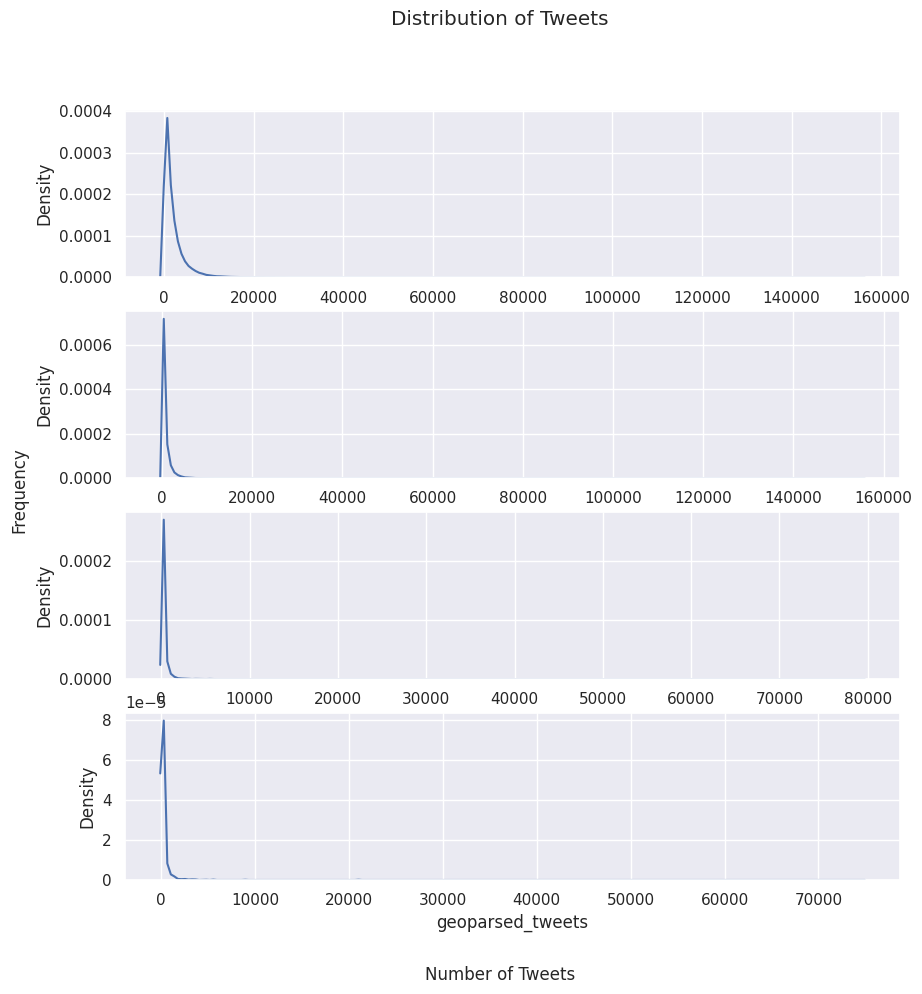

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
sns.set(rc={'figure.figsize':(10,10)})
#sns.set_style(style={'axes.edgecolor': 'black', 'axes.facecolor': 'white'})

fig, axes = plt.subplots(4, 1)
fig.suptitle('Distribution of Tweets')

# Plot the density plot of the "distance" column from ddf_duplicates
sns.kdeplot(data = s["total_tweets"], ax = axes[0])
sns.kdeplot(data = s["geotagged_tweets"], ax = axes[1])
sns.kdeplot(data = s["tweets_with_LOC"], ax = axes[2])
sns.kdeplot(data = s["geoparsed_tweets"], ax = axes[3])

# Plot the density plot of the "distance" column from ddf_noduplicates
#sns.distplot(ddf_noduplicates['distance'], color='red', label='No Duplicates', kde=False)

# Rename axis labels
#plt.xlabel('Distance (km)')
#plt.ylabel('Density')

# Add legend

fig.text(0.5, 0.01, 'Number of Tweets', ha='center')
fig.text(0.01, 0.5, 'Frequency', va='center', rotation='vertical')

#plt.legend()
plt.savefig('user_tweets.png')
plt.show()

In [12]:
import pandas as pd

# users that tweeted from Argentina
argentina = df[df.place_country_code == "AR"].groupby(['username'])["id"].count().reset_index(name='counts_1')

all_ = df.groupby(['username'])["id"].count().reset_index(name='counts_2')

only_argentina = pd.merge(argentina, all_, how="left", on="username")
only_argentina["only_argentina"] = np.where(only_argentina["counts_1"] == only_argentina["counts_2"], "only AR", "elsewhere")
only_argentina = only_argentina[only_argentina.only_argentina == "only AR"]

print("Shape of df: ", only_argentina.shape)
print()
print("The number of users that tweeted only from Argentina was ", only_argentina.shape[0],
      ", which is ", only_argentina.shape[0] / len(all_.username.unique()) * 100,"% of the total users.",
     "This is interesting as they could have still travelled within Argentina.")

Shape of df:  (188, 4)

The number of users that tweeted only from Argentina was  188 , which is  0.21036377267285075 % of the total users. This is interesting as they could have still travelled within Argentina.


In [13]:
"""

import numpy as np
import tqdm

dates = pd.to_datetime(pd.date_range(start='2015-09-27', end='2016-11-06', freq='W', tz="UTC"))

dates_arr = []
for i in range(len(dates)-1):
    dates_arr.append(dates[i:i+2]) 
    
stay_leave = pd.DataFrame({"username": df.username.unique()})

for username in tqdm.tqdm(range(len(stay_leave))):
    
    tweeted_all_months = [None]*len(dates_arr)
    geotagged_all_months = [None]*len(dates_arr)
    
    average_tweets_per_month = [None]*len(dates_arr)
    average_geotagged_per_month = [None]*len(dates_arr)
    
    for i in range(len(dates_arr)):
        
        date = dates_arr[i]
        start_date = date[0]
        end_date = date[1]
        
        mask = (df.username == username) & (df.DateTime > start_date) & (df.DateTime <= end_date)
        
        tweets_this_month = df[mask]
        geotagged_this_month = df[mask & (pd.notnull(df.place_full_name))]
        
        tweeted_all_months[i] = tweets_this_month.shape[0] > 0
        geotagged_all_months[i] = geotagged_this_month.shape[0] > 0
        
        average_tweets_per_month[i] = tweets_this_month.shape[0]
        average_geotagged_per_month[i] = geotagged_this_month.shape[0]
        
    # people who tweeted at least once a month
    stay_leave.loc[stay_leave.username == username, "tweeted_all_weeks"] = tweeted_all_months == True
    stay_leave.loc[stay_leave.username == username, "geotagged_all_weeks"] = geotagged_all_months == True
    
    # number of average tweets per month per user
    stay_leave.loc[stay_leave.username == username, "mean_tweets_per_week"] = np.mean(average_tweets_per_month)
    stay_leave.loc[stay_leave.username == username, "mean_geotagged_per_week"] = np.mean(average_geotagged_per_month)
    
    # number of median tweets per month per user
    #stay_leave.loc[stay_leave.username == username, "median_tweets_per_week"] = np.median(average_tweets_per_month)
    #stay_leave.loc[stay_leave.username == username, "median_geotagged_per_week"] = np.median(average_geotagged_per_month)
""" 

'\n\nimport numpy as np\nimport tqdm\n\ndates = pd.to_datetime(pd.date_range(start=\'2015-09-27\', end=\'2016-11-06\', freq=\'W\', tz="UTC"))\n\ndates_arr = []\nfor i in range(len(dates)-1):\n    dates_arr.append(dates[i:i+2]) \n    \nstay_leave = pd.DataFrame({"username": df.username.unique()})\n\nfor username in tqdm.tqdm(range(len(stay_leave))):\n    \n    tweeted_all_months = [None]*len(dates_arr)\n    geotagged_all_months = [None]*len(dates_arr)\n    \n    average_tweets_per_month = [None]*len(dates_arr)\n    average_geotagged_per_month = [None]*len(dates_arr)\n    \n    for i in range(len(dates_arr)):\n        \n        date = dates_arr[i]\n        start_date = date[0]\n        end_date = date[1]\n        \n        mask = (df.username == username) & (df.DateTime > start_date) & (df.DateTime <= end_date)\n        \n        tweets_this_month = df[mask]\n        geotagged_this_month = df[mask & (pd.notnull(df.place_full_name))]\n        \n        tweeted_all_months[i] = tweets_this_

In [14]:
# number of people who tweeted at least once a week
stay_leave.tweeted_all_weeks.value_counts(dropna=False)

NameError: name 'stay_leave' is not defined

In [ ]:
stay_leave.geotagged_all_weeks.value_counts(dropna=False)

In [ ]:
# number of average tweets per week per user
#stay_leave.mean_tweets_per_week.value_counts(dropna=False)
print("Table ___ shows the mean and median numbers of total tweets and geotagged tweets per user per week.")
print()
print("& Total & Geotagged \\")
print("Mean & ", np.mean(stay_leave.mean_tweets_per_week), " & ", np.mean(stay_leave.mean_geotagged_per_week), " \\")
print("Median & ", np.median(stay_leave.mean_tweets_per_week), " & ", np.median(stay_leave.mean_geotagged_per_week), " \\")